# DATA PREPARATION

#### Importando as bibliotecas e funções

In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from data.load_data import load_data
from features.selection import remove_duplicates, imputar_dados_categoricos, imputar_dados_discretos, imputar_dados_continuos, imputar_target, aplicar_lda_com_nearmiss, calcular_vif, aplicar_pca 
from data.process_data import analisar_qualidade_dados
from visualizations.plot_results import plot_class_distribution_comparison
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'imblearn'

#### Carregando base de dados

In [2]:
# # Carregar e processar os dados
df = load_data('streaming_data.csv')

Dropando coluna `User_id` para simplificar o modelo, assumindo que nào assume relação entre variáveis

In [3]:
df = df.drop(columns='User_id')

Verificação e exclusão das linhas totalmente duplicadas

In [4]:
remove_duplicates(df)


Quantidade de linhas duplicadas encontradas: 12707
Quantidade de linhas duplicadas removidas: 12707


#### Imputação de dados utilizando RandomForestClassifier
##### Documentação:
[scikit-learn - RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

#### Imputação de valores categóricos

In [5]:
analisar_qualidade_dados(df)

Coluna,Zeros,Valores Vazios,Esparsidade
Age,0,11277,14.48%
Gender,0,14516,18.64%
Time_on_platform,5,21420,27.51%
Devices_connected,0,25188,32.34%
Subscription_type,0,25221,32.38%
Num_streaming_services,0,68312,87.71%
Num_active_profiles,0,0,0.00%
Avg_rating,0,17270,22.17%
Churned,46285,16736,80.92%


Valores ausentes antes da imputação: 17527
Valores por categoria após a imputação:
Subscription_type
3.0    29383
1.0    24320
2.0    24181
Name: count, dtype: int64



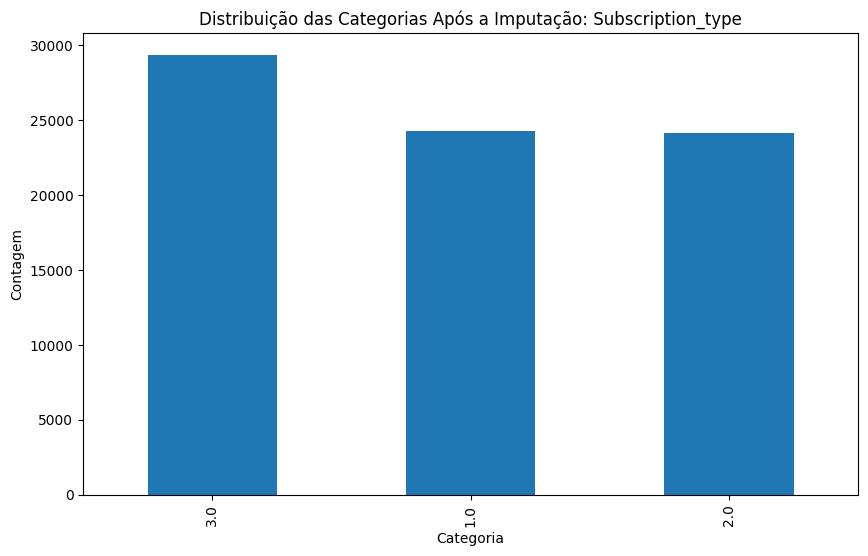

Valores ausentes após a imputação: 0
Total de valores imputados: 17527


In [6]:
imputar_dados_categoricos(df, 'Subscription_type')

Valores ausentes antes da imputação: 31572
Valores por categoria após a imputação:
Gender
1.0    53436
2.0    24448
Name: count, dtype: int64



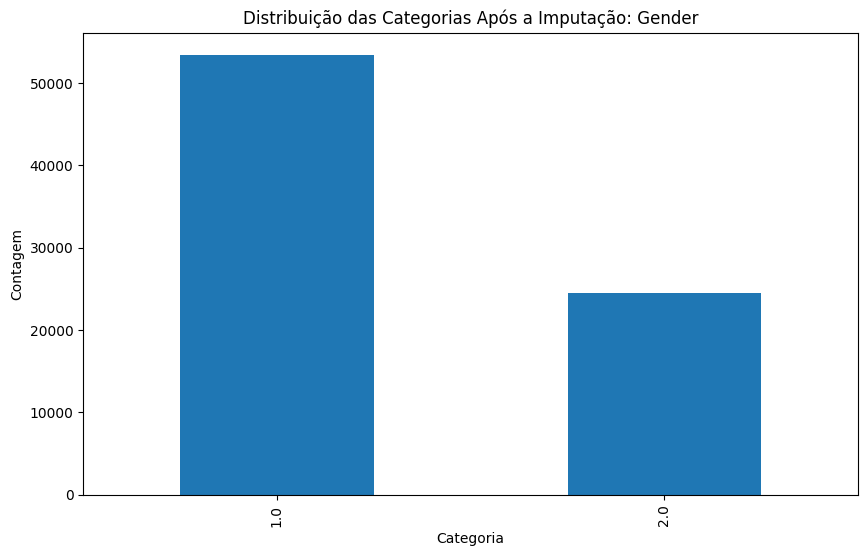

Valores ausentes após a imputação: 0
Total de valores imputados: 31572


In [7]:
# Chama a função
imputar_dados_categoricos(df, 'Gender')

#### Imputação de valores discretos

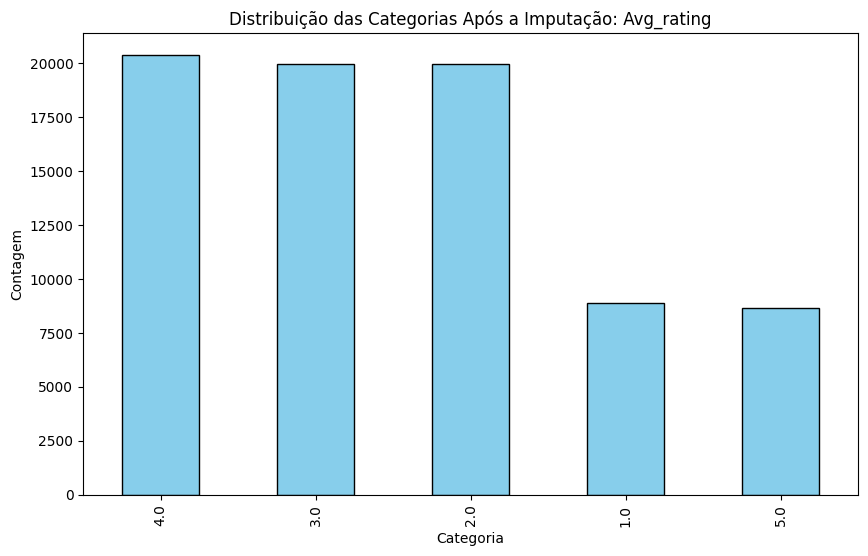

Categoria,Distribuição Antes da Imputação,Distribuição Após a Imputação
nan,17270,0
4.0,15420,20396
2.0,15151,19962
3.0,15088,19985
1.0,7523,8880
5.0,7432,8661


In [8]:
df['Avg_rating'] = round(df['Avg_rating'])
imputar_dados_discretos(df, 'Avg_rating')

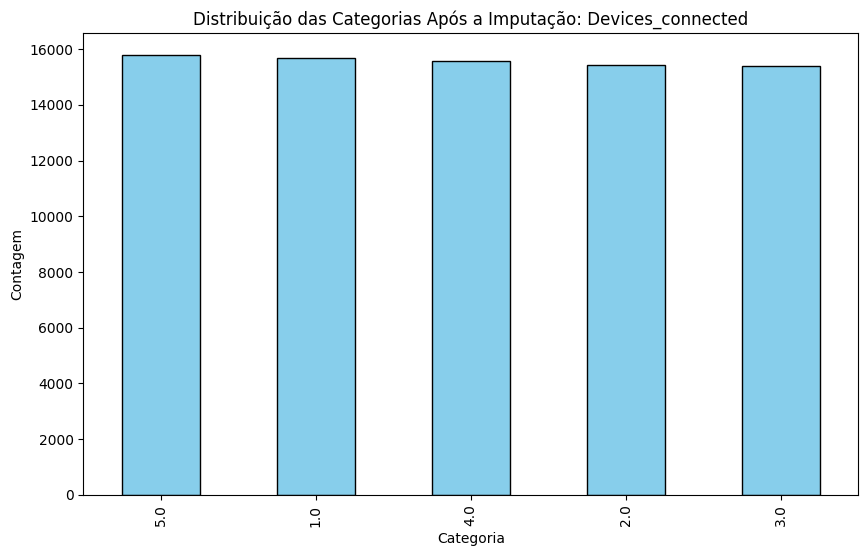

Categoria,Distribuição Antes da Imputação,Distribuição Após a Imputação
nan,25188,0
1.0,10587,15693
4.0,10587,15571
2.0,10583,15413
3.0,10476,15407
5.0,10463,15800


In [9]:
imputar_dados_discretos(df, 'Devices_connected')

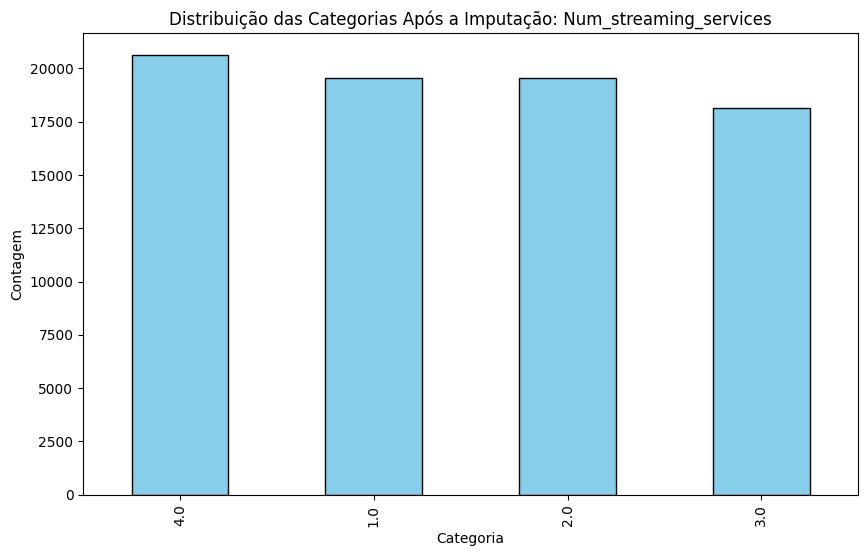

Categoria,Distribuição Antes da Imputação,Distribuição Após a Imputação
nan,68312,0
2.0,2433,19534
4.0,2413,20641
1.0,2401,19559
3.0,2325,18150


In [10]:
imputar_dados_discretos(df, 'Num_streaming_services')

#### Imputação de valores contínuos

In [11]:
imputar_dados_continuos(df, 'Time_on_platform')

Valores ausentes antes da imputação: 21420
Valores ausentes após a imputação: 0
Total de valores imputados: 21420


In [12]:
imputar_dados_continuos(df, 'Age')

Valores ausentes antes da imputação: 11277
Valores ausentes após a imputação: 0
Total de valores imputados: 11277


#### Imputação de valores do Target

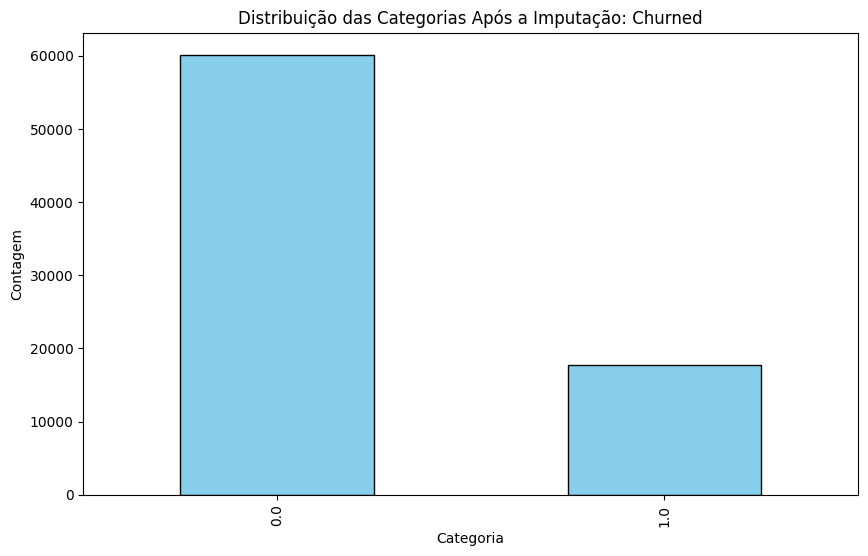

Categoria,Distribuição Antes da Imputação,Distribuição Após a Imputação
0.0,46285,60152
nan,16736,0
1.0,14863,17732


In [13]:
imputar_target(df, 'Churned')

In [14]:
analisar_qualidade_dados(df)

Coluna,Zeros,Valores Vazios,Esparsidade
Age,0,0,0.00%
Gender,0,0,0.00%
Time_on_platform,7,0,0.01%
Devices_connected,0,0,0.00%
Subscription_type,0,0,0.00%
Num_streaming_services,0,0,0.00%
Num_active_profiles,0,0,0.00%
Avg_rating,0,0,0.00%
Churned,60152,0,77.23%


Salvando .csv em 'src/data/processed_data' com os valores vazios imputados

In [15]:
# Definir o caminho absoluto para salvar o CSV
csv_path = os.path.join(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')), 'src/data/processed_data')

# Garantir que a pasta exista
os.makedirs(csv_path, exist_ok=True)

# Salvar o CSV diretamente na pasta correta
df.to_csv(os.path.join(csv_path, 'imputed_data.csv'), index=False)

print("CSV salvo com sucesso!")

CSV salvo com sucesso!


Criação de novas features focada em gerar insights para o modelo identificar um possível churn e melhorando, consequentemente, a sensibilidade (recall)

```python
df = df.assign(
    time_satisfaction = "Detecta a satisfação relativa do cliente ao longo do tempo ativo na plataforma. Clientes com baixa satisfação relativa, mesmo com longo tempo de uso, tendem a churnar.",
    time_satisfaction_total = "Calcula a satisfação total acumulada ao longo do tempo na plataforma. Essa métrica ajuda a identificar clientes que podem ter iniciado satisfeitos, mas perderam interesse com o tempo.",
    Usage = "Calcula o tempo de uso da plataforma em relação à idade do cliente. Clientes jovens com alto uso são mais propensos a continuar engajados.",
    Usage_total = "Mede o uso acumulado da plataforma ao longo da vida do cliente, ponderado pela sua idade. Ajuda a entender o nível de engajamento durante o ciclo de vida do cliente.",
    Usage_stability = "Calcula a estabilidade do uso da plataforma em relação ao número de perfis ativos. Essa métrica é útil para serviços que oferecem perfis múltiplos, como plataformas de streaming.",
    Usage_stability_total = "Pondera o tempo total de uso da plataforma pelo número de perfis ativos. Ajuda a identificar se todos os perfis estão sendo utilizados regularmente.",
    is_high_risk_time = "Identifica clientes em um período crítico de tempo na plataforma, que pode indicar alto risco de churn. Clientes no intervalo de 0 a 4320 dias de uso estão em maior risco.",
    is_high_risk_male = "Identifica clientes do gênero masculino com exatamente 3 dispositivos conectados, o que pode ser um padrão de comportamento associado ao churn.",
    is_basic_subscription = "Identifica clientes que possuem o plano básico de assinatura, que geralmente apresenta maior risco de churn devido a menos benefícios oferecidos.",
    is_high_risk_profiles = "Identifica contas com 4 ou 5 perfis ativos, que podem indicar contas familiares em que o uso desbalanceado pode levar ao churn."
)
```


In [16]:
df = df.assign(
    time_satisfaction = df['Avg_rating'] / (df['Time_on_platform'].fillna(0)),
    time_satisfaction_total = df['Avg_rating'] * (df['Time_on_platform'].fillna(0)),
    Usage = df['Time_on_platform'] / df['Age'].fillna(0),
    Usage_total = df['Time_on_platform'] * df['Age'].fillna(0),
    Usage_stability =df['Time_on_platform'] / df['Num_active_profiles'].fillna(0),
    Usage_stability_total =df['Time_on_platform'] * df['Num_active_profiles'].fillna(0),
    is_high_risk_time = df['Time_on_platform'].apply(lambda x: 1 if 0 <= x <= 4320 else 0),  
    is_high_risk_male = ((df['Gender'] == 1.0) & (df['Devices_connected'].isin([3.0]))).astype(int),
    is_basic_subscription = (df['Subscription_type'] == 2.0).astype(int),
    is_high_risk_profiles = (df['Num_active_profiles'].isin([4, 5])).astype(int)

)

In [17]:
# Substituir NaN por 0 e remover valores infinitos antes de converter para inteiro
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].replace([np.inf, -np.inf], 0)  # Substituir inf e -inf por 0
df[float_columns] = df[float_columns].fillna(0).astype(int)  # Substituir NaN por 0 e converter

##### Normalização dos dados

A Regressão Logística utiliza métodos de otimização, como gradiente descendente, para encontrar os coeficientes. Se as variáveis estão em escalas muito diferentes (por exemplo, uma variável varia de 0 a 1 e outra de 1.000 a 10.000), o processo de otimização pode ser mais lento ou até não convergir. Portanto, antes de selecionar as variáveis e dividi-las em teste e treino, elas foram normalizas com o método min-máx.


##### Modelagem matemática
A fórmula do **Min-Max Scaling** é:

$
X' = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$

Onde:
- $X$: O valor original da variável.
- $X_{\text{min}}$: O valor mínimo da variável no conjunto de dados.
- $X_{\text{max}}$: O valor máximo da variável no conjunto de dados.
- $X'$: O valor escalado para o intervalo [0, 1].


---

[scikit-learn - MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)


In [18]:
# Selecionar as colunas para escalonamento
columns_to_scale = ['Age', 'Gender', 'Time_on_platform', 'Devices_connected',
       'Subscription_type', 'Num_streaming_services', 'Num_active_profiles',
       'Avg_rating', 'time_satisfaction', 'time_satisfaction_total',
       'Usage', 'Usage_total', 'Usage_stability', 'Usage_stability_total',
       'is_high_risk_time', 'is_high_risk_male', 'is_basic_subscription',
       'is_high_risk_profiles']
# Inicializar o MinMaxScaler
scaler = MinMaxScaler()
# Aplicar o escalonamento
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [19]:
# Transformar valores da coluna 'Churned'
df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})
# Verificar as alterações
print(df['Churned'].value_counts())

Churned
No     60152
Yes    17732
Name: count, dtype: int64


In [20]:
# Variáveis preditoras e alvo
X = df.drop(columns=[
                     'Churned', 'Age', 'Time_on_platform', 'Devices_connected',
                     'Subscription_type', 'Num_active_profiles','Avg_rating',
                     'time_satisfaction', 'Gender', 'Num_streaming_services','Usage_stability_total','Usage_stability_total', 'Usage_total' , 'is_basic_subscription'                     
                     ])

y = df['Churned']

#### BALANCEAMENTO DE DADOS

##### Realização da análise da estratégia da distribuição e balanceamento das classes

##### Documentação:
[scikit-learn - NearMiss](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html)



In [21]:
# Análise da estratégia distribuição das classes
y_mapped = y.map({'No': 0, 'Yes': 1})

# Loop com diferentes proporções de NearMiss
for ratio in [0.95, 0.9, 1.0]:
    nearmiss = NearMiss(version=1, sampling_strategy=ratio)
    X_res, y_res = nearmiss.fit_resample(X, y_mapped)

    # Reverter os valores para 'No' e 'Yes'
    y_res = y_res.map({0: 'No', 1: 'Yes'})

    # Mostrar resultados
    print(f"Proporção NearMiss {ratio}: Classe 'No': {Counter(y_res)['No']}, Classe 'Yes': {Counter(y_res)['Yes']}")

Proporção NearMiss 0.95: Classe 'No': 18665, Classe 'Yes': 17732
Proporção NearMiss 0.9: Classe 'No': 19702, Classe 'Yes': 17732
Proporção NearMiss 1.0: Classe 'No': 17732, Classe 'Yes': 17732


##### Balancemento dos dados utilizando o método undersample (NearMiss):
- Como o objetivo é alcançar os padrões relacionados ao _Churned_, foi feito a escolha de balancear por igual os dados referentes a _churned_ 0 (_No_) e  1 (_Yes_),  
visto que o padrão da classe majoritária está mais relacionada com o não _Churned_ e como avaliado anteriormente os resultados estão com as clasess igualadas de _No_ e _Yes_.


```python
nearmiss = NearMiss(
    version = Define a versão da técnica NearMiss,
              Versão 1: Mantém amostras da classe majoritária com menor distância média para as da classe minoritária,
              Versão 2: Considera as amostras mais próximas do ponto médio da classe minoritária,
              Versão 3: Mantém amostras da classe majoritária com as menores distâncias para todas as da classe minoritária

    sampling_strategy = Estratégia para definir a proporção entre as classes após o balanceamento,
                        Ex.: 'auto' (default), uma fração numérica ou um dicionário indicando o número desejado de amostras por classe

    n_neighbors = Número de vizinhos mais próximos usados para calcular as distâncias entre as amostras,
                  Valor padrão é 3. Pode ser ajustado dependendo da densidade dos dados
)
```

##### Documentação:
[scikit-learn - NearMiss](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html)

In [22]:
# Balanceamento dos dados com udersample
nearmiss = NearMiss(
    version = 1,
    sampling_strategy = 1, # estratégia para balanceamento igualitário
    n_neighbors = 20
   )
X_resampled, y_resampled = nearmiss.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[('No', 17732), ('Yes', 17732)]


VISUALIZAÇÃO GRÁFICA DO BALANCEAMENTO

Gráfico de distribuição de classes salvo


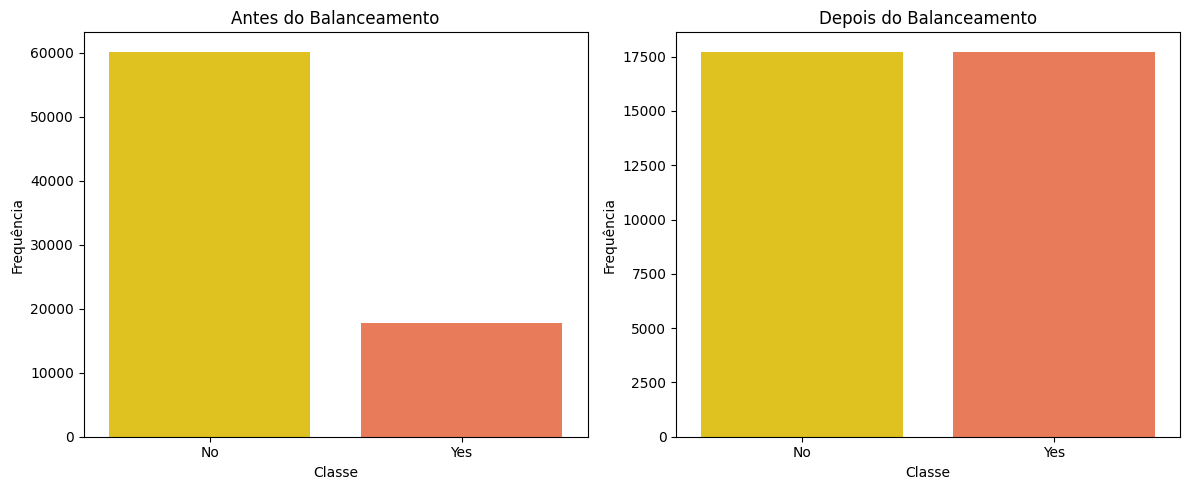

In [24]:
plot_class_distribution_comparison(y, y_resampled, 'Churned', nome_arquivo= "Distribuição de Classe Comparação")

#### DIVISÃO DE TREINO E TESTE

In [25]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2 , random_state=42)

In [26]:
# # # Converter as variáveis-alvo para numéricas
y_train = y_train.map({"Yes": 1, "No": 0})
y_test = y_test.map({"Yes": 1, "No": 0})

### SELEÇÃO DE VARIÁVEIS PARA OTIMIZAÇÃO DO MODELO

Features  ajustadas:
- Variáveis informativas e transformadas reduziram a sobreposição entre as classes, aumentando a confiança do modelo nas probabilidades previstas.
- Essa clareza permitiu que o modelo atingisse um threshold ótimo que favorecesse o recall, sem comprometer drasticamente a precisão.

##### LDA (Linear Discriminant Analysis) - Análise Discriminante Linear

- A utilização do LDA foi realizada porque além da redução da dimensionalidade dos dados ele busca maximizar a separação entre as classes do target, o que pode ajudar a identificar padrões que melhor discriminam as classes, dando o indicativo das variáveis que tem maior peso.

##### Documentação:
[scikit-learn - LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)  
[scikit-learn - NearMiss](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html)

##### PCA (Principal Component Analysis) - Análise de Componentes Principais
- A finalidade da utilização do PCA é o entendimento da quantidade da variância explicada pelos componentes principais relacionando aos dados, o que facilita verificar o impacto dos dados no modelo.
##### Documentação
[scikit-learn - PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)  

In [27]:
aplicar_lda_com_nearmiss(df, 'Churned', ['Churned', 'Age', 'Time_on_platform', 'Devices_connected',
                                         'Subscription_type', 'Num_active_profiles','Avg_rating',
                                         'time_satisfaction', 'Gender', 'Num_streaming_services',
                                         'Usage_stability_total','Usage_stability_total', 'Usage_total' , 
                                         'is_basic_subscription'])

Distribuição das classes após NearMiss: [(0, 17732), (1, 17732)]
Variáveis mais influentes no LDA:
                  Variável      Peso
1                    Usage  4.274497
0  time_satisfaction_total  1.343459
2          Usage_stability  1.316273
4        is_high_risk_male  0.870259
3        is_high_risk_time -0.203683
5    is_high_risk_profiles -0.194843

Acurácia:, 0.7646975891724235
Recall: 0.6720157657657657


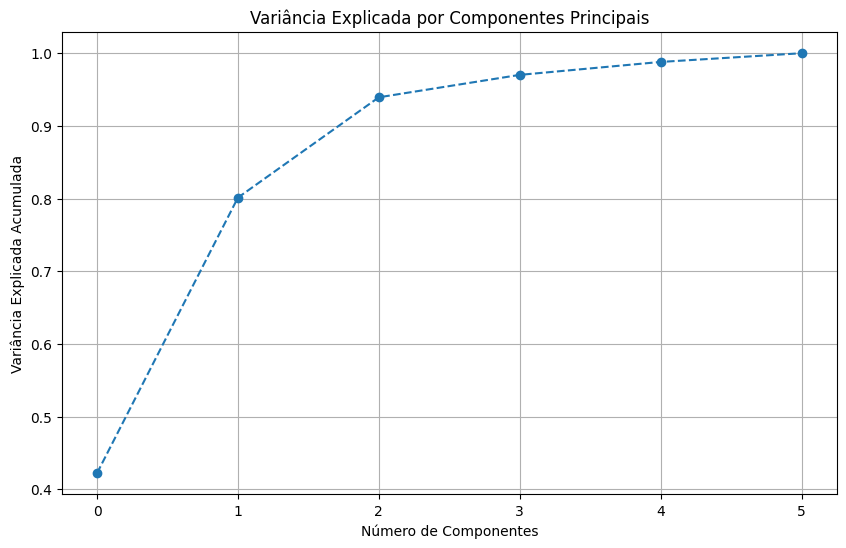

Formato original das features: (28649, 6)
Formato após PCA: (28649, 6)

Contribuição das Features para os Componentes Principais:
                              PC1       PC2       PC3       PC4       PC5  \
time_satisfaction_total -0.261606  0.181701 -0.018960  0.618537 -0.592308   
Usage                   -0.207797  0.141363 -0.014966  0.373408 -0.083630   
Usage_stability         -0.269906  0.027305 -0.013297  0.503684  0.794166   
is_high_risk_time        0.729610 -0.493840  0.025736  0.469254 -0.019208   
is_high_risk_male       -0.042694 -0.000668  0.999023  0.010495 -0.003856   
is_high_risk_profiles    0.530452  0.838079  0.023030  0.063019  0.105326   

                              PC6  
time_satisfaction_total -0.405920  
Usage                    0.888924  
Usage_stability         -0.204526  
is_high_risk_time        0.050597  
is_high_risk_male        0.002174  
is_high_risk_profiles   -0.025454  


In [29]:
aplicar_pca(X_train)

##### _Random Forest_ com feature_importances_

##### -	Identificar quais variáveis são mais relevantes para o modelo de previsão.

##### Documentação:
[scikit-learn - RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

In [28]:
# Treinar o modelo Random Forest com os dados balanceados e transformados
rf_var_lr = RandomForestClassifier(
    n_estimators = 50,
    max_depth = 5,
    min_samples_split = 2,
    min_samples_leaf = 2,
    max_features = 'sqrt',
    oob_score = True,
    bootstrap = True,
    random_state = 42,
    verbose = 0,
    class_weight = 'balanced'  # Lidar com classes desbalanceadas
)
rf_var_lr.fit(X_resampled, y_resampled)
feature_importances = pd.Series(rf_var_lr.feature_importances_, index=X_resampled.columns)
print(feature_importances.sort_values(ascending=False))

Usage                      0.410347
Usage_stability            0.245830
is_high_risk_time          0.179137
time_satisfaction_total    0.126056
is_high_risk_male          0.026665
is_high_risk_profiles      0.011965
dtype: float64


### MULTICOLINEARIDADE

##### Documentação:
[statsmodels - variance_inflation_factor](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

In [29]:
calcular_vif(X_resampled)

,feature,VIF
0,time_satisfaction_total,5.017917
1,Usage,4.893039
2,Usage_stability,3.502625
3,is_high_risk_time,1.635197
4,is_high_risk_male,1.102463
5,is_high_risk_profiles,2.128818


Salvando arquivo .csv com os dados processados em 'src/data/processed_data'

In [30]:
# Definir o caminho absoluto para salvar o CSV
csv_path = os.path.join(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')), 'src/data/processed_data')

# Garantir que a pasta exista
os.makedirs(csv_path, exist_ok=True)

# Salvar o CSV diretamente na pasta correta
df.to_csv(os.path.join(csv_path, 'processed_data.csv'), index=False)

print("CSV salvo com sucesso!")

CSV salvo com sucesso!


Salvando objetos em .pkl - variáveis precessadas

In [31]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/data/processed_data
src_path = os.path.join(project_path, 'src/data/processed_data')
os.makedirs(src_path, exist_ok=True)

# Salvar arquivos diretamente na pasta correta
joblib.dump(X_train, os.path.join(src_path, 'X_train.pkl'))
joblib.dump(X_test, os.path.join(src_path, 'X_test.pkl'))
joblib.dump(y_train, os.path.join(src_path, 'y_train.pkl'))
joblib.dump(y_test, os.path.join(src_path, 'y_test.pkl'))
print("Dados salvos com sucesso!")

Dados salvos com sucesso!


Salvando objetos em .pkl - modelo treinado

In [32]:
# Obter o caminho absoluto do diretório do projeto
project_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..'))

# Caminho completo para a pasta src/data/interim
src_path = os.path.join(project_path, 'src/data/interim')
os.makedirs(src_path, exist_ok=True)

# Salvar arquivos diretamente na pasta correta
joblib.dump(X_resampled, os.path.join(src_path, 'X_resampled.pkl'))
joblib.dump(y_resampled, os.path.join(src_path, 'y_resampled.pkl'))
print("Dados salvos com sucesso!")

Dados salvos com sucesso!
